# Emotion Analysis

Import the datasets needed, in our case, Goemotions

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers, Model
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
import keras_nlp

In [1]:
uploaded = files.upload()

Saving goemotions_1.csv to goemotions_1.csv
Saving goemotions_2.csv to goemotions_2.csv
Saving goemotions_3.csv to goemotions_3.csv


In [1]:
df_1 = pd.read_csv("goemotions_1.csv")
df_2 = pd.read_csv("goemotions_2.csv")
df_3 = pd.read_csv("goemotions_3.csv")

df_1_n = df_1.drop(columns=['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear'])
df_2_n = df_2.drop(columns=['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear'])
df_3_n = df_3.drop(columns=['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear'])

df_all = pd.concat([df_1_n, df_2_n], ignore_index=True)

Because of the high volume of data, just the first two datasets will be used to train the model, with the last used to test

In [4]:
train_ds, val_ds = train_test_split(df_all, test_size=0.2)
test_ds = df_3_n

print(train_ds.shape)
print(val_ds.shape)
print(test_ds.shape)

(112000, 29)
(28000, 29)
(71225, 29)


## Emotion Count

Checking if the dataset is balanced or not

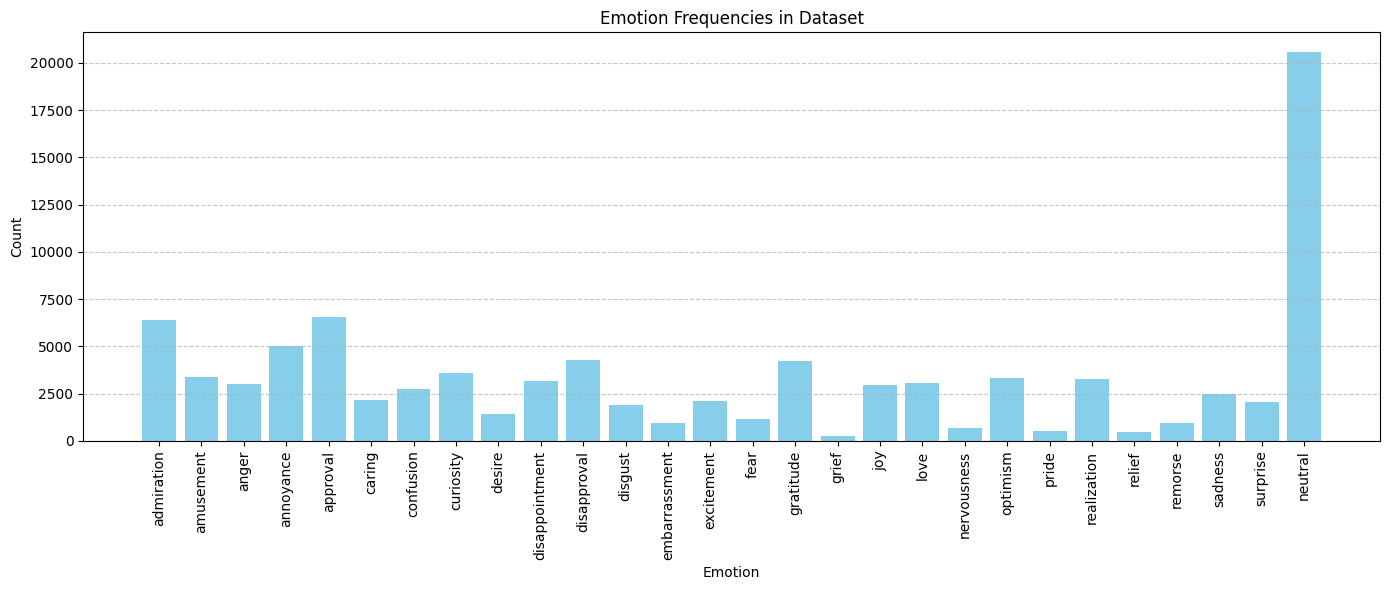

In [ ]:
# List of GoEmotions labels
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness",
    "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

# Count emotion occurrences from the dataset
emotion_counts = tf.zeros([28], dtype=tf.int32)

# Iterate through the DataFrame using iterrows()
for _, row in train_ds.iterrows():
    labels = row.drop('text').values  # Assuming 'text' is the text column
    # Convert the labels to NumPy int type before casting to tf.int32
    labels = labels.astype(np.int32)
    emotion_counts += tf.cast(labels, tf.int32)

# Convert to numpy
emotion_counts = emotion_counts.numpy()

plt.figure(figsize=(14, 6))
plt.bar(emotion_labels, emotion_counts, color="skyblue")
plt.xticks(rotation=90)
plt.title("Emotion Frequencies in Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Create a DataFrame from the emotion labels and counts
summary_df = pd.DataFrame({'Emotion': emotion_labels, 'Count': emotion_counts})

summary_df

,Emotion,Count
0,admiration,6411
1,amusement,3373
2,anger,2999
3,annoyance,5030
4,approval,6532
5,caring,2148
6,confusion,2737
7,curiosity,3566
8,desire,1428
9,disappointment,3156


## MLP

Common sense benchmark: 26.4 accuracy, if every sentence is neutral

In [6]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=25000,
    output_mode="multi_hot")

text_only_train_ds = train_ds["text"]
text_vectorization.adapt(text_only_train_ds)

In [7]:
binary_1gram_train_ds = tf.data.Dataset.from_tensor_slices((train_ds['text'].values, train_ds.drop(columns=['text']).values)).map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
binary_1gram_val_ds = tf.data.Dataset.from_tensor_slices((val_ds['text'].values, val_ds.drop(columns=['text']).values)).map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
binary_1gram_test_ds = tf.data.Dataset.from_tensor_slices((test_ds['text'].values, test_ds.drop(columns=['text']).values)).map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

batch_size = 64
binary_1gram_train_ds = binary_1gram_train_ds.batch(batch_size)
binary_1gram_val_ds = binary_1gram_val_ds.batch(batch_size)
binary_1gram_test_ds = binary_1gram_test_ds.batch(batch_size)

In [8]:
for example in binary_1gram_train_ds.take(1):
    print("Input shape:", example[0].shape)
    print("Label shape:", example[1].shape)

Input shape: (64, 25000)
Label shape: (64, 28)


### MLP 1: using only one hidden layer

Using only one hidden layer, with 32 relus, in order to do not make an information bottleneck as we have 28 sigmoid activations

In [10]:
def get_model(max_tokens=25000, hidden_dim=32):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(28, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy", AUC(multi_label=True)])  # You can add more metrics if needed

    return model

model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram_1.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2)
]

model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=50,
          callbacks=callbacks)

model = keras.models.load_model("binary_2gram_1.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 25000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       800,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │           924 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800,956 (3.06 MB)

 Trainable params: 800,956 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.1986 - auc_1: 0.5062 - loss: 0.2432 - val_accuracy: 0.3001 - val_auc_1: 0.6695 - val_loss: 0.1459 - learning_rate: 0.0010
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3084 - auc_1: 0.6150 - loss: 0.1509 - val_accuracy: 0.3364 - val_auc_1: 0.7256 - val_loss: 0.1385 - learning_rate: 0.0010
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3359 - auc_1: 0.6774 - loss: 0.1435 - val_accuracy: 0.3541 - val_auc_1: 0.7537 - val_loss: 0.1340 - learning_rate: 0.0010
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3512 - auc_1: 0.7143 - loss: 0.1384 - val_accuracy: 0.3624 - val_auc_1: 0.7690 - val_loss: 0.1312 - learning_rate: 0.0010
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3598 - auc_1: 0.7401 - loss: 0.1350 - val_accuracy: 0.3695 - val_auc_1: 0.7791 - val_loss: 0.1292 - learning_rate: 0.0010
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms

### MLP 2: 2 hidden layers

Adding more hidden layers, to improve metrics and train faster. The model will also overfit much faster

In [11]:
def get_model(max_tokens=25000, hidden_dim=256):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(hidden_dim // 2, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(28, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", AUC(multi_label=True)])

    return model

model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2)
]

model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 25000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,400,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,436,764 (24.55 MB)

 Trainable params: 6,436,764 (24.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.2665 - auc_2: 0.6008 - loss: 0.1897 - val_accuracy: 0.3795 - val_auc_2: 0.8015 - val_loss: 0.1254 - learning_rate: 0.0010
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3897 - auc_2: 0.7864 - loss: 0.1272 - val_accuracy: 0.3915 - val_auc_2: 0.8149 - val_loss: 0.1226 - learning_rate: 0.0010
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4224 - auc_2: 0.8360 - loss: 0.1173 - val_accuracy: 0.3905 - val_auc_2: 0.8152 - val_loss: 0.1232 - learning_rate: 0.0010
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4458 - auc_2: 0.8640 - loss: 0.1107 - val_accuracy: 0.3861 - val_auc_2: 0.8122 - val_loss: 0.1252 - learning_rate: 0.0010
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4760 - auc_2: 0.8875 - loss: 0.1037 - val_accuracy: 0.3808 - val_auc_2: 0.8116 - val_loss: 0.1275 - learning_rate: 2.0000e-04
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step

In [13]:
model.save("binary_2gram.h5")

In [14]:
import json

# Get config
config = text_vectorization.get_config()

# Get vocabulary
vocab = text_vectorization.get_vocabulary()

# Save config to JSON
with open("text_vectorization_config.json", "w") as f:
    json.dump(config, f)

# Save vocabulary to plain text or JSON
with open("text_vectorization_vocab.json", "w") as f:
    json.dump(vocab, f)


### MLP: Test inference

In [13]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["I feel absolutely the worst of the world today!"],
])

predictions = inference_model(raw_text_data)

emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness",
    "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

for label, prob in zip(emotion_labels, predictions[0]):
    print(f"{label:15}: {float(prob) * 100:.2f}%")


admiration     : 1.41%
amusement      : 0.68%
anger          : 10.64%
annoyance      : 20.69%
approval       : 3.04%
caring         : 1.25%
confusion      : 1.01%
curiosity      : 0.84%
desire         : 0.66%
disappointment : 23.07%
disapproval    : 9.26%
disgust        : 29.96%
embarrassment  : 10.65%
excitement     : 0.46%
fear           : 6.28%
gratitude      : 0.20%
grief          : 1.26%
joy            : 0.40%
love           : 0.22%
nervousness    : 3.01%
optimism       : 2.69%
pride          : 0.38%
realization    : 3.34%
relief         : 0.58%
remorse        : 2.94%
sadness        : 14.48%
surprise       : 1.65%
neutral        : 8.03%


## LSTM

In [12]:
from tensorflow.keras import layers
max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    )

text_vectorization.adapt(text_only_train_ds)

In [13]:
int_train_ds = tf.data.Dataset.from_tensor_slices((train_ds['text'].values, train_ds.drop(columns=['text']).values)).map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_val_ds = tf.data.Dataset.from_tensor_slices((val_ds['text'].values, val_ds.drop(columns=['text']).values)).map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_test_ds = tf.data.Dataset.from_tensor_slices((test_ds['text'].values, test_ds.drop(columns=['text']).values)).map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

In [14]:
for example in int_train_ds.take(1):
    print("Input shape:", example[0].shape)
    print("Label shape:", example[1].shape)

Input shape: (600,)
Label shape: (28,)


### LSTM: GRU + embedding + masking

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
    ]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

In [ ]:
model.save("emotions_lstm.h5")

import json

# Get config
config = text_vectorization.get_config()

# Get vocabulary
vocab = text_vectorization.get_vocabulary()

# Save config to JSON
with open("emotions_lstm_config.json", "w") as f:
    json.dump(config, f)

# Save vocabulary to plain text or JSON
with open("emotions_lstm_vocab.json", "w") as f:
    json.dump(vocab, f)


### LSTM: Glove

In [15]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-05-14 22:18:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-14 22:18:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-14 22:18:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [16]:
import numpy as np

path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [17]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
  if i < max_tokens:
    embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
    )

In [18]:
def preprocess_text(text, label):
    # Filter out empty or whitespace-only text entries
    text = tf.strings.strip(text)  # Strip leading/trailing whitespace
    if text == "":
        return False  # Skip this example

    # Filter out entries that result in empty sequences after tokenization
    tokenized_text = text_vectorization(text)
    if tf.shape(tokenized_text)[0] == 0:
        return False  # Skip this example

    return True

int_train_ds = tf.data.Dataset.from_tensor_slices((train_ds['text'].values, train_ds.drop(columns=['text']).values))
int_train_ds = int_train_ds.filter(preprocess_text)  # Apply filtering
int_train_ds = int_train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_train_ds = int_train_ds.batch(batch_size)

int_val_ds = tf.data.Dataset.from_tensor_slices((val_ds['text'].values, val_ds.drop(columns=['text']).values))
int_val_ds = int_val_ds.filter(preprocess_text)  # Apply filtering
int_val_ds = int_val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_val_ds = int_val_ds.batch(batch_size)

int_test_ds = tf.data.Dataset.from_tensor_slices((test_ds['text'].values, test_ds.drop(columns=['text']).values))
int_test_ds = int_test_ds.filter(preprocess_text)  # Apply filtering
int_test_ds = int_test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_test_ds = int_test_ds.batch(batch_size)

In [19]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.GRU(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(28, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", AUC(multi_label=True)])

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2)
]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=50, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 100) │  2,000,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     25,728 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 28)        │      1,820 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,027,548 (7.73 MB)

 Trainable params: 27,548 (107.61 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/50
   1748/Unknown 29s 13ms/step - accuracy: 0.2211 - auc_3: 0.5253 - loss: 0.2054

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.2212 - auc_3: 0.5254 - loss: 0.2054 - val_accuracy: 0.3379 - val_auc_3: 0.7251 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.3427 - auc_3: 0.6813 - loss: 0.1430 - val_accuracy: 0.3581 - val_auc_3: 0.7655 - val_loss: 0.1325 - learning_rate: 0.0010
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.3553 - auc_3: 0.7184 - loss: 0.1383 - val_accuracy: 0.3656 - val_auc_3: 0.7835 - val_loss: 0.1299 - learning_rate: 0.0010
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.3612 - auc_3: 0.7367 - loss: 0.1360 - val_accuracy: 0.3682 - val_auc_3: 0.7901 - val_loss: 0.1288 - learning_rate: 0.0010
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.3639 - auc_3: 0.7459 - loss: 0.1346 - val_accuracy: 0.3714 - val_auc_3: 0.7955 - val_loss: 0.1278 - learning_rate: 0.0010
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/

In [21]:
model.save("emotions_glove.h5")

import json

# Get config
config = text_vectorization.get_config()

# Get vocabulary
vocab = text_vectorization.get_vocabulary()

# Save config to JSON
with open("emotions_glove_text_vectorization_config.json", "w") as f:
    json.dump(config, f)

# Save vocabulary to plain text or JSON
with open("emotions_glove_text_vectorization_vocab.json", "w") as f:
    json.dump(vocab, f)


### LSTM: Test inference

In [22]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["I’m overflowing with pure joy and gratitude today—the sun is shining, my heart is light, every moment feels magical, and I can’t stop smiling! Life is beautiful, full of kindness, laughter, and endless possibility. Everything feels right, and I’m so excited for what’s ahead. Happiness is absolutely everywhere!"],
])

predictions = inference_model(raw_text_data)

emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness",
    "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

for label, prob in zip(emotion_labels, predictions[0]):
    print(f"{label:15}: {float(prob) * 100:.2f}%")


admiration     : 32.14%
amusement      : 5.43%
anger          : 0.24%
annoyance      : 0.81%
approval       : 9.77%
caring         : 1.51%
confusion      : 0.29%
curiosity      : 1.12%
desire         : 0.82%
disappointment : 0.75%
disapproval    : 0.26%
disgust        : 0.11%
embarrassment  : 0.14%
excitement     : 25.95%
fear           : 0.14%
gratitude      : 4.49%
grief          : 0.04%
joy            : 40.65%
love           : 5.46%
nervousness    : 0.19%
optimism       : 3.76%
pride          : 1.77%
realization    : 2.53%
relief         : 1.28%
remorse        : 0.11%
sadness        : 0.37%
surprise       : 3.16%
neutral        : 7.02%


## Transformer

Preprocess the text data to make it a simpler model. We will only consider the most common 10,000 words. Allow for a maximum sequence length of 250. This keeps the model simple and faster

In [24]:
max_features = 15000
sequence_length = 250
vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

AUTOTUNE = tf.data.AUTOTUNE
train_text = tf.data.Dataset.from_tensor_slices(train_ds['text'].values)
train_text = train_text.batch(128).prefetch(AUTOTUNE)  # Batch and prefetch for performance

vectorize_layer.adapt(train_text)


In [25]:
train_ds_2 = (
    tf.data.Dataset.from_tensor_slices((train_ds['text'].values, train_ds.drop(columns=['text']).values))
    .batch(128)
    .map(lambda x, y: (vectorize_layer(x), y))
    .prefetch(AUTOTUNE)
)

val_ds_2 = (
    tf.data.Dataset.from_tensor_slices((val_ds['text'].values, val_ds.drop(columns=['text']).values))
    .batch(128)
    .map(lambda x, y: (vectorize_layer(x), y))
    .prefetch(AUTOTUNE)
)

test_ds_2 = (
    tf.data.Dataset.from_tensor_slices((test_ds['text'].values, test_ds.drop(columns=['text']).values))
    .batch(128)
    .map(lambda x, y: (vectorize_layer(x), y))
    .prefetch(AUTOTUNE)
)

# Check shape
for x_batch, y_batch in train_ds_2.take(1):
    print(x_batch.shape)  # (batch_size, 250)
    print(y_batch.shape)  # (batch_size, 28)


(128, 250)
(128, 28)


In [29]:
# Create positional encoding
def get_positional_encoding(seq_length, d_model):
    # Calculate positional encoding
    positions = np.arange(seq_length)[:, np.newaxis]
    depths = np.arange(d_model)[np.newaxis, :] // 2 * 2  # Integer division

    # Create angle rates
    angle_rates = 1 / np.power(10000, (2 * (depths // 2)) / np.float32(d_model))
    angle_rads = positions * angle_rates

    # Apply sin/cos to even/odd indices
    pos_encoding = np.zeros(angle_rads.shape)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.cast(pos_encoding, dtype=tf.float32)


# Create a basic transformer model
def create_transformer_model():
    inputs = layers.Input(shape=(sequence_length,))

    embdding_dim = 128

    # Embedding layer for text
    embedding_layer = layers.Embedding(max_features,  embdding_dim,  mask_zero=True)(inputs)

    # Embedding layer for positional encoding
    pos_encoding = get_positional_encoding(sequence_length,  embdding_dim)
    pos_encoding = tf.keras.backend.constant(pos_encoding)

    embedded_with_pos = embedding_layer + pos_encoding

    # Transformer block
    transformer_block = layers.MultiHeadAttention(
        num_heads=4, key_dim=64
    )(embedded_with_pos, embedded_with_pos)

    norm_transformer_block = layers.LayerNormalization(epsilon=1e-6)(transformer_block + embedded_with_pos)

    # Feed Forward Network
    ffn = layers.Dense(128, activation='relu')(norm_transformer_block)
    ffn = layers.Dense(128)(ffn)
    ffn = layers.Dropout(0.1)(ffn)
    ffn_output = layers.LayerNormalization(epsilon=1e-6)(norm_transformer_block + ffn)

    # Global pooling and output
    pooled = layers.GlobalAveragePooling1D()(ffn_output)
    dropout = layers.Dropout(0.1)(pooled)
    outputs = layers.Dense(28, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    return model


# Create and compile the model
model = create_transformer_model()
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(multi_label=True)]
)

model.summary()

In [30]:
# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2)
]

model.fit(train_ds_2, validation_data=val_ds_2, epochs=30,callbacks=callbacks)
model = keras.models.load_model("transformer.keras")
print(f"Test acc: {model.evaluate(test_ds_2)[1]:.3f}")

Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.2172 - auc_5: 0.5002 - loss: 0.2127 - val_accuracy: 0.2600 - val_auc_5: 0.5048 - val_loss: 0.1574 - learning_rate: 1.0000e-04
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2603 - auc_5: 0.5010 - loss: 0.1604 - val_accuracy: 0.2600 - val_auc_5: 0.5351 - val_loss: 0.1569 - learning_rate: 1.0000e-04
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2617 - auc_5: 0.5149 - loss: 0.1592 - val_accuracy: 0.3041 - val_auc_5: 0.5954 - val_loss: 0.1501 - learning_rate: 1.0000e-04
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3221 - auc_5: 0.5957 - loss: 0.1483 - val_accuracy: 0.3517 - val_auc_5: 0.6700 - val_loss: 0.1404 - learning_rate: 1.0000e-04
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3576 - auc_5: 0.6662 - loss: 0.1402 - val_accuracy: 0.3647 - val_auc_5: 0.7165 - val_loss: 0.1360 - learning_rate: 1.0000e-04
Epoch 6/30
875/875 ━━━━━━━━━━━━━━━━━━━

In [33]:
model.save("emotions_transformer_model.h5")

import json

# Get config
config = vectorize_layer.get_config()

# Get vocabulary
vocab = vectorize_layer.get_vocabulary()

# Save config to JSON
with open("emotions_transformer_text_vectorization_config.json", "w") as f:
    json.dump(config, f)

# Save vocabulary to plain text or JSON
with open("emotions_transformer_text_vectorization_vocab.json", "w") as f:
    json.dump(vocab, f)

### Transformer: Test inference

In [35]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = vectorize_layer(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["I’m overflowing with pure joy and gratitude today—the sun is shining, my heart is light, every moment feels magical, and I can’t stop smiling! Life is beautiful, full of kindness, laughter, and endless possibility. Everything feels right, and I’m so excited for what’s ahead. Happiness is absolutely everywhere!"],
])

predictions = inference_model(raw_text_data)

emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness",
    "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

for label, prob in zip(emotion_labels, predictions[0]):
    print(f"{label:15}: {float(prob) * 100:.2f}%")


admiration     : 6.50%
amusement      : 6.21%
anger          : 2.33%
annoyance      : 6.33%
approval       : 5.99%
caring         : 0.76%
confusion      : 0.03%
curiosity      : 0.04%
desire         : 0.15%
disappointment : 2.60%
disapproval    : 3.73%
disgust        : 2.30%
embarrassment  : 0.21%
excitement     : 0.87%
fear           : 0.92%
gratitude      : 0.62%
grief          : 0.19%
joy            : 10.79%
love           : 1.77%
nervousness    : 0.22%
optimism       : 0.21%
pride          : 0.18%
realization    : 0.85%
relief         : 0.72%
remorse        : 0.06%
sadness        : 2.50%
surprise       : 0.23%
neutral        : 41.18%


## BERT

In [26]:
import keras_nlp
import tensorflow as tf

# Parameters
sequence_length = 128
bert_preset = "bert_base_en"

# Load preprocessor
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    bert_preset,
    sequence_length=sequence_length
)

100%|██████████| 510/510 [00:00<00:00, 909kB/s]


100%|██████████| 548/548 [00:00<00:00, 1.06MB/s]


100%|██████████| 208k/208k [00:00<00:00, 276kB/s]
Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [33]:
train_ds_3 = (
    tf.data.Dataset.from_tensor_slices((train_ds['text'].values, train_ds.drop(columns=['text']).values))
    .batch(128)
    .map(lambda x, y: (preprocessor(x), y))
    .prefetch(AUTOTUNE)
)

val_ds_3 = (
    tf.data.Dataset.from_tensor_slices((val_ds['text'].values, val_ds.drop(columns=['text']).values))
    .batch(128)
    .map(lambda x, y: (preprocessor(x), y))
    .prefetch(AUTOTUNE)
)

test_ds_3 = (
    tf.data.Dataset.from_tensor_slices((test_ds['text'].values, test_ds.drop(columns=['text']).values))
    .batch(128)
    .map(lambda x, y: (preprocessor(x), y))
    .prefetch(AUTOTUNE)
)

In [34]:
# Parameters
sequence_length = 128
bert_preset = "bert_base_en"

# Load BERT backbone
bert_backbone = keras_nlp.models.BertBackbone.from_preset(bert_preset)
bert_backbone.trainable = False  # freeze

# Input
text_input = keras.Input(shape=(), dtype=tf.string, name="text")

# This input layer is a placeholder to match tokenized structure
token_ids = keras.Input(shape=(sequence_length,), dtype=tf.int32, name="token_ids")
segment_ids = keras.Input(shape=(sequence_length,), dtype=tf.int32, name="segment_ids")
padding_mask = keras.Input(shape=(sequence_length,), dtype=tf.int32, name="padding_mask")

# Pass through frozen BERT encoder
encoder_output = bert_backbone({
    "token_ids": token_ids,
    "segment_ids": segment_ids,
    "padding_mask": padding_mask
})
cls_output = encoder_output["pooled_output"]

# Classification head
output = layers.Dense(28, activation="sigmoid", name="classifier")(cls_output)

# Model
model = keras.Model(
    inputs={"token_ids": token_ids, "segment_ids": segment_ids, "padding_mask": padding_mask},
    outputs=output
)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", AUC(multi_label=True)]
)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("bert_frozen_classifier.keras", save_best_only=True)
]

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 768),     │ 108,310,2… │ padding_mask[0][… │
│ (BertBackbone)      │ (None, 128, 768)] │            │ segment_ids[0][0… │
│                     │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 28)        │     21,532 │ bert_backbone[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 108,331,804 (413.25 MB)

 Trainable params: 21,532 (84.11 KB)

 Non-trainable params: 108,310,272 (413.17 MB)

In [35]:
model.fit(
    train_ds_3,
    validation_data=val_ds_3,
    epochs=5,
    callbacks=callbacks
)

# Evaluate
model = keras.models.load_model("bert_frozen_classifier.keras", safe_mode=False)
print(f"Test acc: {model.evaluate(test_ds_3)[1]:.3f}")

Epoch 1/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 312s 318ms/step - accuracy: 0.2591 - auc_4: 0.5491 - loss: 0.1647 - val_accuracy: 0.2843 - val_auc_4: 0.6913 - val_loss: 0.1493
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 271s 309ms/step - accuracy: 0.2879 - auc_4: 0.6546 - loss: 0.1479 - val_accuracy: 0.2943 - val_auc_4: 0.7203 - val_loss: 0.1457
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 270s 309ms/step - accuracy: 0.2944 - auc_4: 0.6835 - loss: 0.1449 - val_accuracy: 0.3008 - val_auc_4: 0.7348 - val_loss: 0.1436
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 270s 309ms/step - accuracy: 0.2971 - auc_4: 0.6991 - loss: 0.1433 - val_accuracy: 0.3055 - val_auc_4: 0.7434 - val_loss: 0.1423
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 271s 309ms/step - accuracy: 0.2995 - auc_4: 0.7097 - loss: 0.1421 - val_accuracy: 0.3056 - val_auc_4: 0.7505 - val_loss: 0.1416
557/557 ━━━━━━━━━━━━━━━━━━━━ 136s 233ms/step - accuracy: 0.3056 - auc_4: 0.7516 - loss: 0.1407
Test acc: 0.307


In [36]:
model.save("bert_model.h5")

In [38]:
# Get config
config = preprocessor.get_config()

# Save config to JSON
with open("bert_text_vectorization_emotions_config.json", "w") as f:
    json.dump(config, f)

### BERT: Test inference

In [ ]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["I’m overflowing with pure joy and gratitude today—the sun is shining, my heart is light, every moment feels magical, and I can’t stop smiling! Life is beautiful, full of kindness, laughter, and endless possibility. Everything feels right, and I’m so excited for what’s ahead. Happiness is absolutely everywhere!"],
])

predictions = inference_model(raw_text_data)

emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness",
    "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

for label, prob in zip(emotion_labels, predictions[0]):
    print(f"{label:15}: {float(prob) * 100:.2f}%")
